
# How to Save the Pipeline Memory Efficiently

Our pipeline offers extensive insights into the dynamics of training and other intermediate results.  
When re-using the pipeline (with `.save` and `.load` functionality), this can create very large binary files, especially when working with large datasets.  

Therefore, the default way of saving the pipeline is by discarding most of the training dynamics and intermediate results.  
In this tutorial, we show:  
- Which data is kept and which is discarded. <br><br>
- The trade-offs in visualizing and evaluating a saved pipeline. <br><br>
- How to save the complete pipeline including all training dynamics and intermediate results. <br><br>

## Theory: What Data is Kept?

### Result Object
The main driver of memory is the `result` attribute of our pipeline. For recall, these are all attributes:

```python
        latentspaces: TrainingDynamics object storing latent space representations for 'train', 'valid', and 'test' splits.
        sample_ids: TrainingDynamics object storing sample identifiers for 'train', 'valid', and 'test' splits.
        reconstructions: TrainingDynamics object storing reconstructed outputs for 'train', 'valid', and 'test' splits.
        mus: TrainingDynamics object storing mean values of latent distributions for 'train', 'valid', and 'test' splits.
        sigmas: TrainingDynamics object storing standard deviations of latent distributions for 'train', 'valid', and 'test' splits.
        losses: TrainingDynamics object storing the total loss for different epochs and splits ('train', 'valid', 'test').
        sub_losses: LossRegistry object (extendable) for all sublosses.
        preprocessed_data: torch.Tensor containing data after preprocessing.
        model: final trained torch.nn.Module model.
        model_checkpoints: TrainingDynamics object storing model state at each checkpoint.
        datasets: Optional[DatasetContainer] containing train, valid, and test datasets.
        new_datasets: Optional[DatasetContainer] containing new train, valid, and test datasets.
        adata_latent: Optional[AnnData] containing latent representations as AnnData.
        final_reconstruction: Optional[Union[DataPackage, MuData]] containing final reconstruction results.
        sub_results: Optional[Dict[str, Any]] containing sub-results for multi-task or multi-modal models.
        sub_reconstructions: Optional[Dict[str, Any]] containing sub-reconstructions for multi-task or multi-modal models.
        embedding_evaluation: pd.DataFrame containing embedding evaluation results.
```
We save the following:  
- model
- adata_latent <br><br>
All other attributes are set to empty default values.
### Pipeline

We keep all other pipeline attributes, except `._visualizer`, because this stores plots which can be misleading when rerunning the pipeline and seeing old plots that do not fit the new data.  

All other attributes are kept. This is especially relevant for the `config` and the `_preprocessor`.  
Whenever you perform any pipeline step, it will use the initial config you passed when first creating the pipeline.  
The preprocessor is necessary because when running `predict` with new data, this should be preprocessed the same way as initially (e.g., which genes to keep, how the scalers were fitted, etc.).

**IMPORTANT**
> When calling `.save`, the `result` attribute is modified in-place (to avoid copies).  
> This means after calling `.save`, your current pipeline object does not contain information from the other result objects.  
> This applies to the pipeline object in current memory, not only to the pipeline object after loading.  
> If you want to avoid this, please run `.save(save_all=True)`.


## Practical Examples
### First we run a varix pipeline 

In [ ]:
from autoencodix.utils.example_data import EXAMPLE_MULTI_SC
from autoencodix.configs.varix_config import VarixConfig
from autoencodix.configs.default_config import DataCase
import autoencodix as acx

my_config = VarixConfig(
    learning_rate=0.001,
    epochs=5,
    checkpoint_interval=5,
    default_vae_loss="kl",  # kl or mmd possible
    data_case=DataCase.MULTI_SINGLE_CELL,
)
print("\n")
print("Starting Pipeline")
print("-" * 50)
print("-" * 50)
varix = acx.Varix(data=EXAMPLE_MULTI_SC, config=my_config)
result = varix.run()



Starting Pipeline
--------------------------------------------------
--------------------------------------------------
in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
mudata: View of MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
shape of obj: (1000, 700)
obj: View of MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'
      uns:	'log1p'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'
      uns:	'log1p'
len(ind): 700
max of index998
ind: [  0   1   2   3   4   6   8  10  11  12  13  14  15  16  17  18  19  21
  23  25  28  31  32  33  35  36  37  38  39  40  41  42  44  46  48  49
  50  51  52  53  54  55  57  59  60  61  65  68  69  70  71 

#### Saving and Loading Explained

Here we first check the latent space (could be any other training dynamic) before saving.  
After saving, we see that the `result` object got cleaned and only `model`, `adata_latent`, and `embedding_evaluation` are kept.


In [2]:
ls_before_save = result.latentspaces.get(epoch=-1, split="test")
print("Length of latentspace before saving")
print(len(ls_before_save))
varix.save("varix_backup.pkl")
ls_after_save = result.latentspaces.get()
print("Length of latentspace after saving")
print(len(ls_after_save))

Length of latentspace before saving
200
Preprocessor saved successfully.
saving memory efficient
Field(name='model',type=<class 'torch.nn.modules.module.Module'>,default=<dataclasses._MISSING_TYPE object at 0x1062fdb40>,default_factory=<class 'torch.nn.modules.module.Module'>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD)
Field(name='adata_latent',type=typing.Optional[anndata._core.anndata.AnnData],default=<dataclasses._MISSING_TYPE object at 0x1062fdb40>,default_factory=<class 'anndata._core.anndata.AnnData'>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD)
Pipeline object saved successfully.
Model state saved successfully.
Length of latentspace after saving
0


#### Implications for Visualization
We load the model and see the implications of this in `visualize`.


In [3]:
varix_loaded = acx.Varix().load("varix_backup.pkl")

Attempting to load a pipeline from varix_backup.pkl...
Pipeline object loaded successfully. Actual type: Varix
Preprocessor loaded successfully.
Model state loaded successfully.


In [4]:
varix_loaded.visualize()

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/visualize/_general_visualizer.py:51: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Number of columns must be a positive integer, not 0
  warnings.warn(


<Figure size 0x500 with 0 Axes>

> Note that we code a `UserWarning`. This is expected, since it tells us that we cannot visualize loss plots anymore because the data for this is no longer in the result object.  
> However, we could run a predict step on the trained model to get some visualizations.


In [5]:
res_loaded = varix_loaded.predict(data=EXAMPLE_MULTI_SC)

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
mudata: View of MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'
      uns:	'log1p'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'
      uns:	'log1p'
Processing 1 MuData objects: ['multi_sc']
Processing test split
Processing test modality: multi_sc
n_samples in format recon: 1000
train
n_samples from datatpackge: {'paired_count': 1000}


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/visualize/_general_visualizer.py:51: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Number of columns must be a positive integer, not 0
  warnings.warn(


Creating plots ...
Absolute loss plot not found in the plots dictionary
This happens, when you did not run visualize() or if you saved and loaded the model with `save_all=False`


<Figure size 0x500 with 0 Axes>

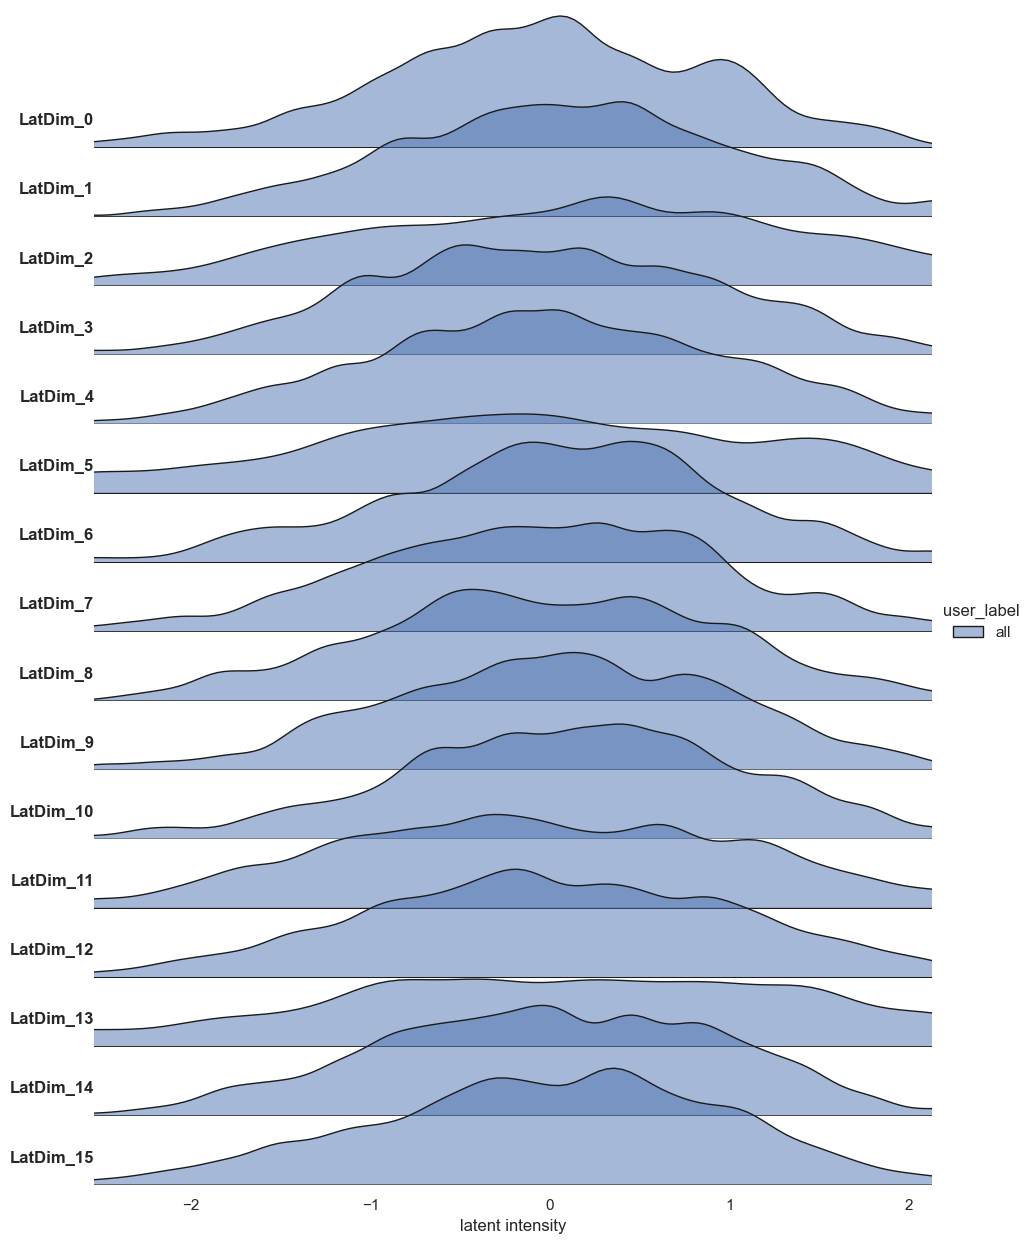

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


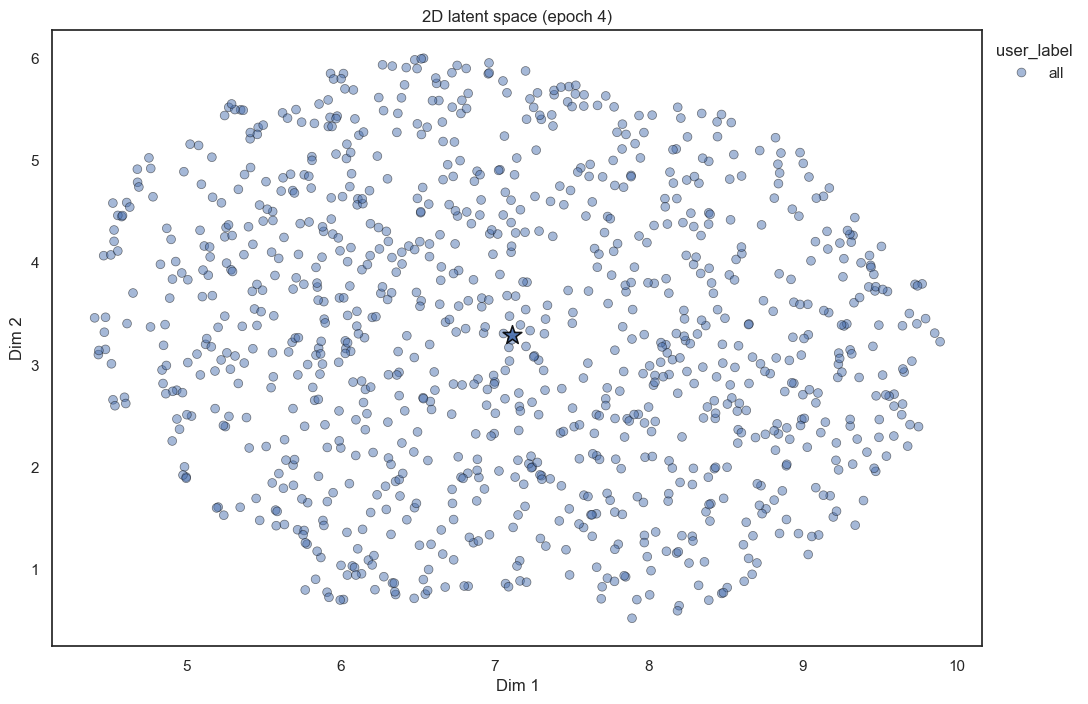

In [6]:
varix_loaded.visualize()
# we use test split here, because predict with new data is equal to test split
varix_loaded.show_result(split="test")

#### Implications for Evaluate
The evaluate step is not supported for this memory-efficient saving as of now, and you'll get the following warning:


In [7]:
res_eval = varix_loaded.evaluate()

Perform ML task with feature df: Latent
Latent


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:344: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: tuple index out of range
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:344: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: tuple index out of range
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/visualize/_general_visualizer.py:606: UserWarning: We could not create visualizations for the evalua

## How to Keep All Data
When you really want to investigate all training dynamics and results, we recommend setting `save_all=True`. See below:


In [ ]:
from autoencodix.utils.example_data import EXAMPLE_MULTI_BULK

my_config = VarixConfig(
    learning_rate=0.001,
    epochs=5,
    checkpoint_interval=5,
    default_vae_loss="kl",  # kl or mmd possible
    data_case=DataCase.MULTI_BULK,
)
n_varix = acx.Varix(data=EXAMPLE_MULTI_BULK, config=my_config)
result_new = n_varix.run()
n_varix.save(file_path="new_varix.pkl", save_all=True)

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
anno key: transcriptomics
anno key: proteomics
Epoch 1 - Train Loss: 28.3496
Sub-losses: recon_loss: 28.3495, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 21.6855
Sub-losses: recon_loss: 21.6855, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 27.2090
Sub-losses: recon_loss: 27.2076, var_loss: 0.0014, anneal_factor: 0.0025, effective_beta_factor: 0.0002
Epoch 2 - Valid Loss: 22.0868
Sub-losses: recon_loss: 22.0864, var_loss: 0.0004, anneal_factor: 0.0025, effective_beta_factor: 0.0002
Epoch 3 - Train Loss: 25.5954
Sub-losses: recon_loss: 25.5267, var_loss: 0.0687, anneal_factor: 0.1192, effective_beta_factor: 0.0119
Epoch 3 - Valid Loss: 22.0341
Sub-losses: recon_loss: 22.0083, var_loss: 0.0258, anneal_factor: 0.1192, effective_beta_factor: 0.0119
Epoch 4 - Train Loss: 25.2607
Sub-losses: recon_loss: 24.730

Now we can load the pipeline and all intermediate data is kept.

In [9]:
loaded_all_varix = acx.Varix().load(file_path="new_varix.pkl")

Attempting to load a pipeline from new_varix.pkl...
Pipeline object loaded successfully. Actual type: Varix
Preprocessor loaded successfully.
Model state loaded successfully.


In [10]:
loaded_all_varix.visualize()

Creating plots ...


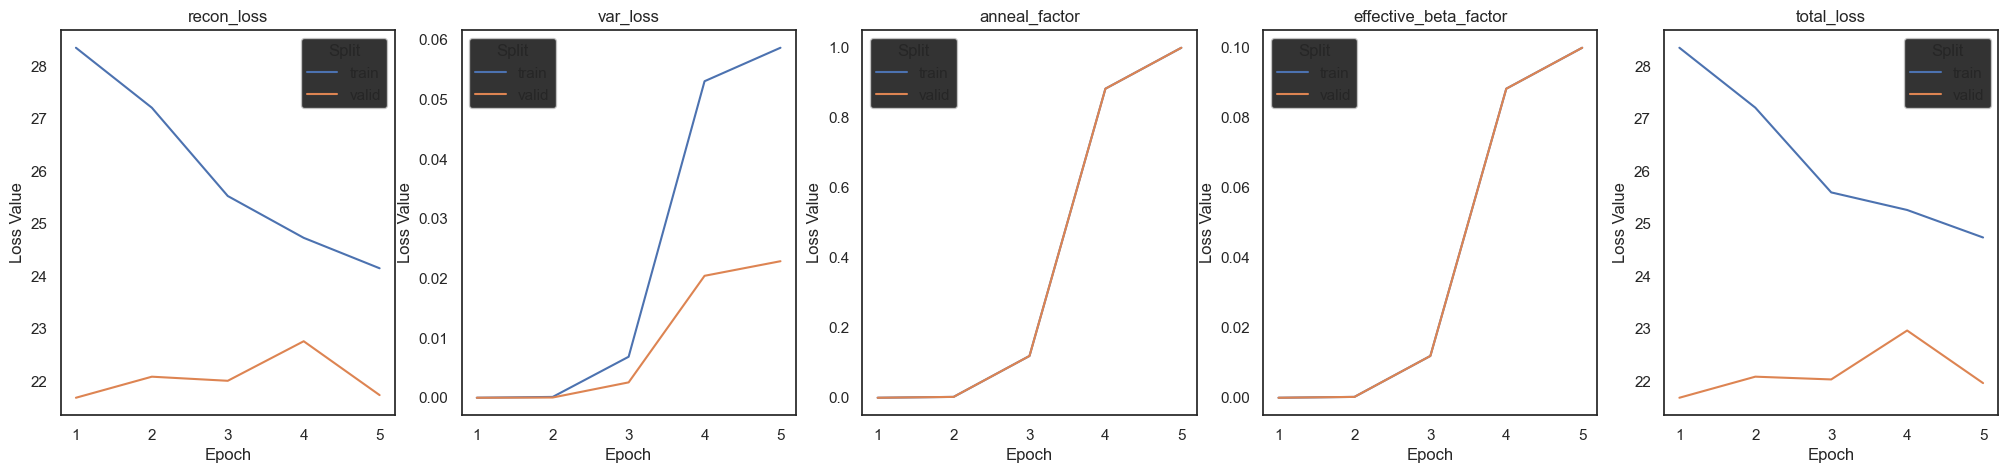

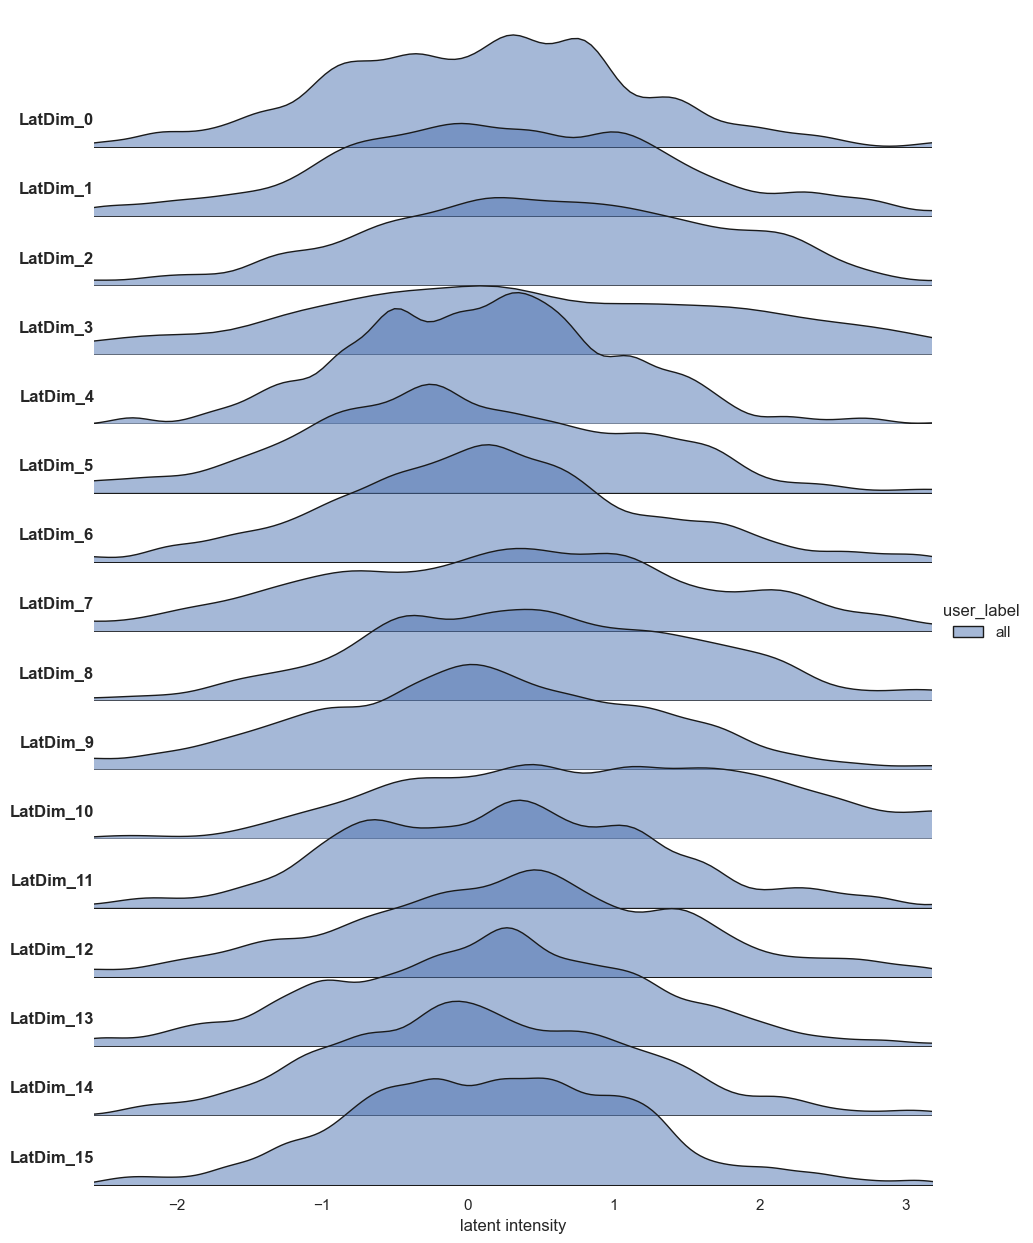

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


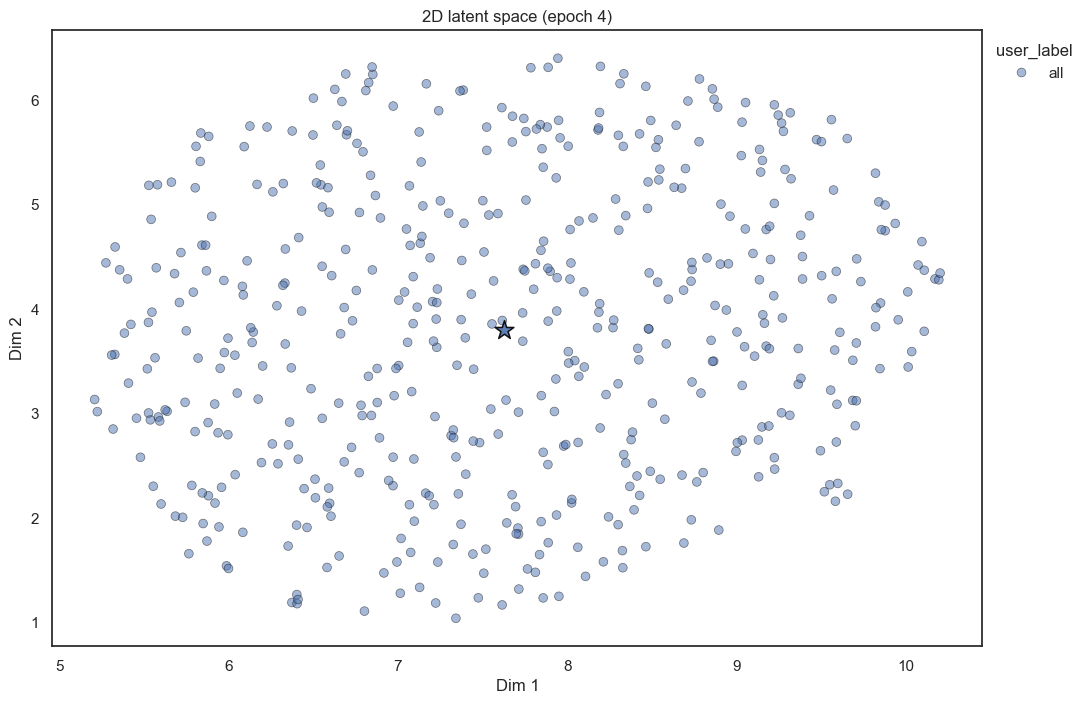

In [11]:
loaded_all_varix.show_result()

And we see that the loss plots from the initial training are still present.

## Implications for Ontix and XModalix
These two pipelines offer more/other visualizations.
### XModalix

In [ ]:
import os
import glob
import autoencodix as acx

from autoencodix.configs.xmodalix_config import XModalixConfig
from autoencodix.configs.default_config import DataConfig, DataInfo, DataCase

p = os.getcwd()
d = "autoencodix_package"
if d not in p:
    raise FileNotFoundError(f"'{d}' not found in path: {p}")
os.chdir(os.sep.join(p.split(os.sep)[: p.split(os.sep).index(d) + 1]))
print(f"Changed to: {os.getcwd()}")

clin_file = os.path.join("data/XModalix-Tut-data/combined_clin_formatted.parquet")
rna_file = os.path.join("data/XModalix-Tut-data/combined_rnaseq_formatted.parquet")
img_root = os.path.join("data/XModalix-Tut-data/images/tcga_fake")

xmodalix_config = XModalixConfig(
    checkpoint_interval=5,
    class_param="CANCER_TYPE_ACRONYM",
    epochs=6,
    latent_dim=8,
    requires_paired=False,
    pretrain_epochs=2,
    data_case=DataCase.IMG_TO_BULK,
    data_config=DataConfig(
        data_info={
            "img": DataInfo(
                file_path=img_root,
                data_type="IMG",
                scaling="MINMAX",
                translate_direction="to",
                pretrain_epochs=2,
                # extra_anno_file=imganno_file,
            ),
            "rna": DataInfo(
                file_path=rna_file,
                data_type="NUMERIC",
                scaling="MINMAX",
                translate_direction="from",
            ),
            "anno": DataInfo(file_path=clin_file, data_type="ANNOTATION", sep="\t"),
        },
    ),
)

xmodalix = acx.XModalix(config=xmodalix_config)
result = xmodalix.run()
outpath = os.path.join("tutorial_res", "xmodalix.pkl")
xmodalix.save(file_path=outpath)

# the load functionality automatically will build the pipeline object out of the three saved files
xmodalix_loaded = acx.XModalix.load("xmodalix.pkl")
# now you can use the model to predict with a different pair again:

r = xmodalix_loaded.predict(from_key="RNA", to_key="RNA2")

Changed to: /Users/maximilianjoas/development/autoencodix_package
reading parquet: data/XModalix-Tut-data/combined_rnaseq_formatted.parquet
reading parquet: data/XModalix-Tut-data/combined_clin_formatted.parquet
Given image size is possible, rescaling images to: 64x64
Successfully loaded 3230 images for img
anno key: rna
anno key: img
Converting 2261 images to torch.float32 tensors...
Converting 646 images to torch.float32 tensors...
Converting 323 images to torch.float32 tensors...
key: train, type: <class 'dict'>
key: valid, type: <class 'dict'>
key: test, type: <class 'dict'>
Check if we need to pretrain: multi_bulk.rna
pretrain epochs : 2
Starting Pretraining for: multi_bulk.rna with <class 'autoencodix.trainers._general_trainer.GeneralTrainer'>
Epoch 1 - Train Loss: 3.6437
Sub-losses: recon_loss: 3.6437, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 1.0709
Sub-losses: recon_loss: 1.0709, var_loss: 0.0000, anneal_factor: 0.0000, effect

In [21]:
xmodalix_loaded.visualize()

In [16]:
xmodalix_loaded.evaluate()

Perform ML task with feature df: Latent_$_multi_bulk.RNA
Processing dataset: multi_bulk.RNA
Processing dataset: multi_bulk.RNA2
Processing dataset: img.IMG
Processing dataset: multi_bulk.RNA
Processing dataset: multi_bulk.RNA2
Processing dataset: img.IMG
Processing dataset: multi_bulk.RNA
Processing dataset: multi_bulk.RNA2
Processing dataset: img.IMG
Latent_$_multi_bulk.RNA
Perform ML task with feature df: Latent_$_multi_bulk.RNA2
Processing dataset: multi_bulk.RNA
Processing dataset: multi_bulk.RNA2
Processing dataset: img.IMG
Processing dataset: multi_bulk.RNA
Processing dataset: multi_bulk.RNA2
Processing dataset: img.IMG
Processing dataset: multi_bulk.RNA
Processing dataset: multi_bulk.RNA2
Processing dataset: img.IMG
Latent_$_multi_bulk.RNA2
Perform ML task with feature df: Latent_$_img.IMG
Processing dataset: multi_bulk.RNA
Processing dataset: multi_bulk.RNA2
Processing dataset: img.IMG
Processing dataset: multi_bulk.RNA
Processing dataset: multi_bulk.RNA2
Processing dataset: im

AttributeError: 'DataFrame' object has no attribute 'CLINIC_PARAM'

### Ontix

In [17]:

import autoencodix as acx
from autoencodix.configs.default_config import DefaultConfig
from autoencodix.configs.ontix_config import OntixConfig

from autoencodix.utils.example_data import (
    EXAMPLE_PROCESSED_DATA,
)

# EXAMPLE_DATA hold PyTorch Datasets (child with extra info) with metdata for train, test and valid splits
processed_data = EXAMPLE_PROCESSED_DATA


ont_lvl1 = dict()
ont_lvl2 = dict()

ont_lvl1["pwy-1"] = ["sub-pwy-1", "sub-pwy-2"]
ont_lvl1["pwy-2"] = ["sub-pwy-2"]
ont_lvl1["pwy-3"] = ["sub-pwy-1", "sub-pwy-3"]
# first third of feature ids in processed_data.train.feature_ids
ont_lvl2["sub-pwy-1"] = processed_data.train.feature_ids[: int(len(processed_data.train.feature_ids) / 3)]
# second third of feature ids in processed_data.train.feature_ids
ont_lvl2["sub-pwy-2"] = processed_data.train.feature_ids[
	int(len(processed_data.train.feature_ids) / 3) : int(2 * len(processed_data.train.feature_ids) / 3)
]
# last third of feature ids in processed_data.train.feature_ids
ont_lvl2["sub-pwy-3"] = processed_data.train.feature_ids[
	int(2 * len(processed_data.train.feature_ids) / 3) : int(len(processed_data.train.feature_ids))
]

# ont_lvl2["sub-pwy-1"] = ["gene-1", "gene-2"]
# ont_lvl2["sub-pwy-2"] = ["gene-3", "gene-4"]
# ont_lvl2["sub-pwy-3"] = ["gene-2", "gene-6"]

ontology_tuple = ( ont_lvl1, ont_lvl2 )

# Write each dictionary in ontology_tuple to a separate text file
for i, ont_dict in enumerate(ontology_tuple):
	file_name = f"ontology_level_{i+1}.txt"
	with open(file_name, "w") as f:
		for key, values in ont_dict.items():
			for value in values:
				f.write(f"{value}\t{key}\n")
print("Ontology dictionaries written to ontology_level_1.txt and ontology_level_2.txt")

ont_files = ["ontology_level_1.txt", "ontology_level_2.txt"]

Ontology dictionaries written to ontology_level_1.txt and ontology_level_2.txt


In [18]:

ontix = acx.Ontix(ontologies=ont_files, sep="\t", config=OntixConfig(epochs=5, learning_rate=0.005,n_layers=1), data=processed_data)
result_onitx = ontix.run()

Ontix checks:
All possible feature names length: 30
Feature order length: 30
Feature names without filtering: 30
Mask layer 0 with shape torch.Size([3, 3]) and 5.0 connections
Mask layer 1 with shape torch.Size([30, 3]) and 30.0 connections
Latent Dim: 3
Epoch 1 - Train Loss: 1225.5647
Sub-losses: recon_loss: 1225.5646, var_loss: 0.0001, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 1209.1338
Sub-losses: recon_loss: 1209.1336, var_loss: 0.0002, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 1205.5973
Sub-losses: recon_loss: 1205.5860, var_loss: 0.0113, anneal_factor: 0.0025, effective_beta_factor: 0.0025
Epoch 2 - Valid Loss: 1183.2005
Sub-losses: recon_loss: 1183.1848, var_loss: 0.0158, anneal_factor: 0.0025, effective_beta_factor: 0.0025
Epoch 3 - Train Loss: 1172.7428
Sub-losses: recon_loss: 1171.7010, var_loss: 1.0419, anneal_factor: 0.1192, effective_beta_factor: 0.1192
Epoch 3 - Valid Loss: 1140.3844
Sub-losses: recon_loss:

In [ ]:
ontix.save(file_path="ontix_backup.pkl")


Preprocessor saved successfully.
saving memory efficient
Field(name='model',type=<class 'torch.nn.modules.module.Module'>,default=<dataclasses._MISSING_TYPE object at 0x1062fdb40>,default_factory=<class 'torch.nn.modules.module.Module'>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD)
Field(name='adata_latent',type=typing.Optional[anndata._core.anndata.AnnData],default=<dataclasses._MISSING_TYPE object at 0x1062fdb40>,default_factory=<class 'anndata._core.anndata.AnnData'>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD)
Pipeline object saved successfully.
Model state saved successfully.


In [ ]:
ontix_loaded = acx.Ontix(ontologies=ont_files).load(file_path="ontix_backup.pkl")

Attempting to load a pipeline from onitx_backup.pkl...
Pipeline object loaded successfully. Actual type: Ontix
Preprocessor loaded successfully.
Model state loaded successfully.


In [22]:
pred_res = ontix_loaded.predict(EXAMPLE_PROCESSED_DATA)

In [23]:
ontix_loaded.visualize()

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/visualize/_general_visualizer.py:51: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Number of columns must be a positive integer, not 0
  warnings.warn(


Creating plots ...
Absolute loss plot not found in the plots dictionary
This happens, when you did not run visualize() or if you saved and loaded the model with `save_all=False`


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:344: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Shape of passed values is (0, 1), indices imply (0, 3)
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:344: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Shape of passed values is (0, 1), indices imply (0, 3)
  warnings.warn(


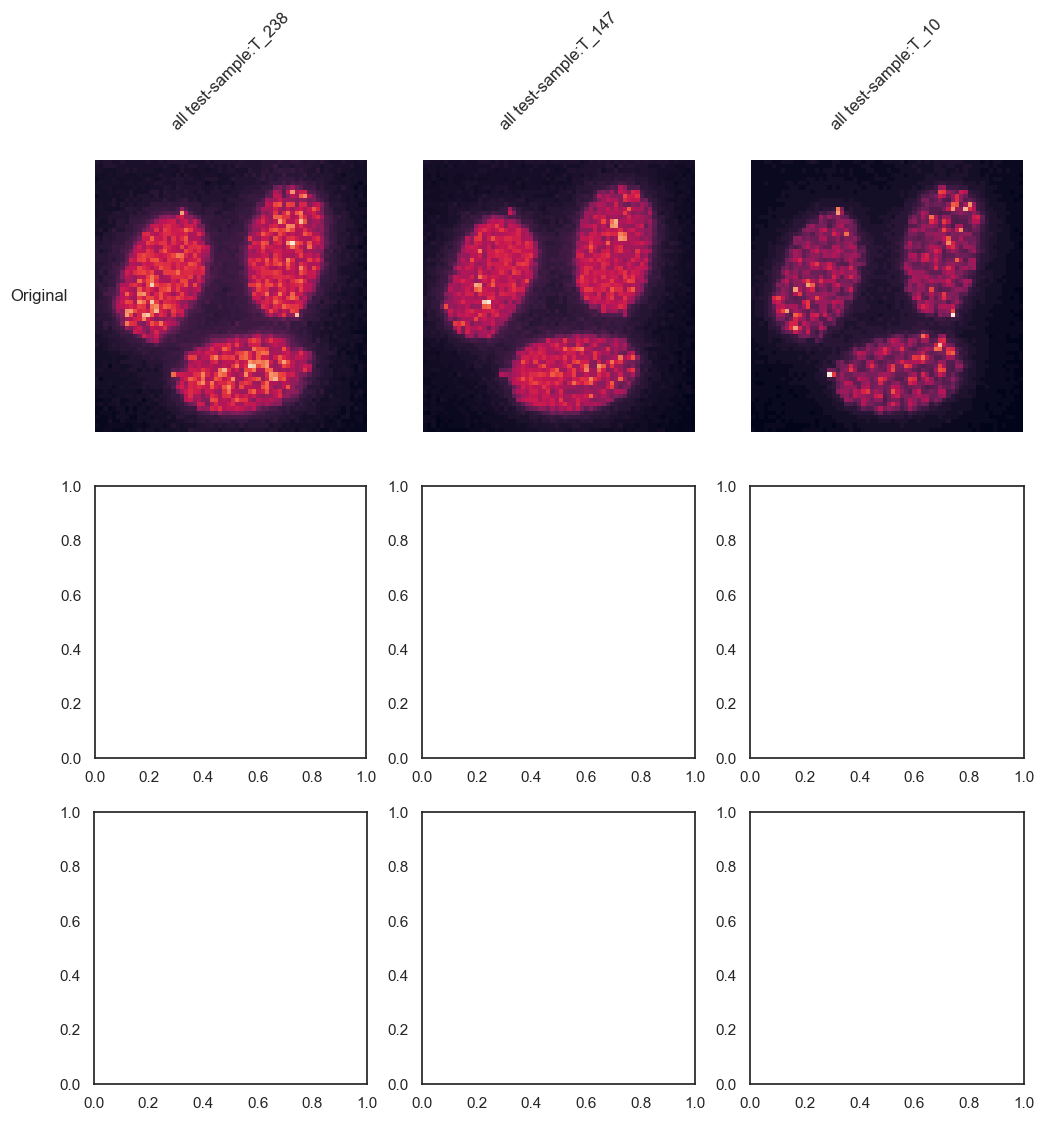

<Figure size 0x500 with 0 Axes>

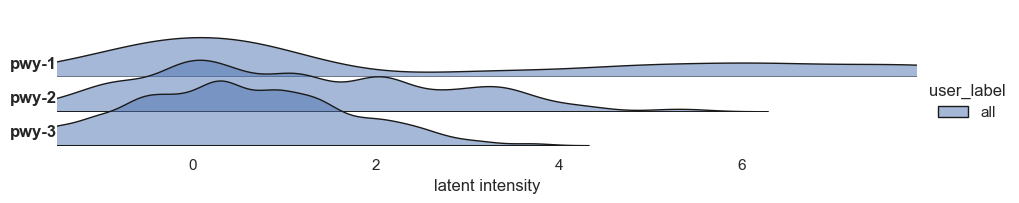

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:344: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Shape of passed values is (0, 1), indices imply (0, 3)
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:344: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Shape of passed values is (0, 1), indices imply (0, 3)
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/depreca

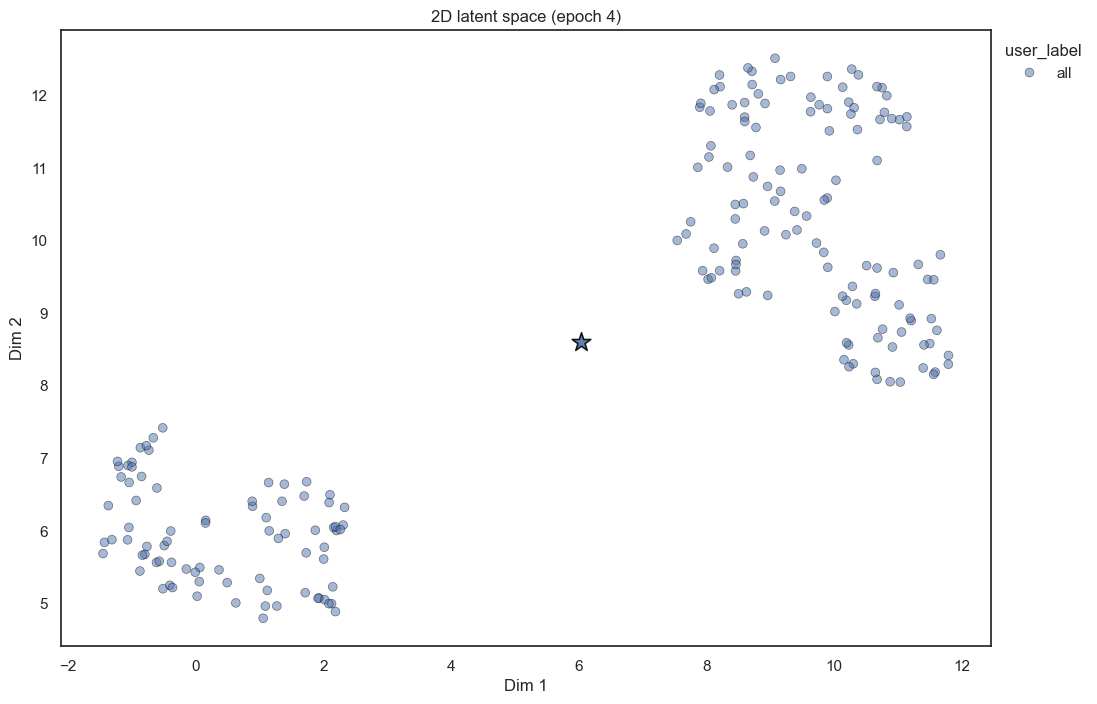

In [24]:
ontix_loaded.show_result()

In [ ]:
ontix_loaded.evaluate()

Perform ML task with feature df: Latent
Latent
Perform ML task with feature df: Latent
Latent
Perform ML task with feature df: Latent
Latent
Perform ML task with feature df: Latent
Latent


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:344: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Shape of passed values is (0, 1), indices imply (0, 3)
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:344: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Shape of passed values is (0, 1), indices imply (0, 3)
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:344: UserWarning: We co

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={})
preprocessed_data: Tensor of shape (0,)
model: OntixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=None, valid=None, test=None)
new_datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x339f52260>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x33a8f61d0>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x33a8f47c0>)
adata_latent: AnnData object with n_obs × n_vars = 201 × 3
    uns: 'var_names'
final_reconstruction: <autoencodix.data._numeric_dataset.NumericDataset object at 0x3743ab970>
sub_results: None
sub_reconstructions: None
embedding_evaluation: Empty Data